# Analysing Connectivity of Public Transport in Singapore
**Bernice Ong Hwee Yee, Luo Xinming**

The goal of the backend analysis is to construct a pipeline that calculates the **connectivity score** for each of the 55 planning areas in Singapore. Connectivity is broken down into: 
1. **Availability**
- Number of train stations in the region
- Number of bus stops in the region
- Number of bus routes in the region
- Average frequency of buses (min) in each region (Frequency of Dispatch for Bus Services in the region)
 
2. **Accessibility**
- Differences in Travel Time (min) between taking Public and Private Transport (eg car) to:
  - CBD (Business)
  -  ION Orchard (Leisure)
  -  SGH (Healthcare)

## Data Collection


### Transport Services
We made API calls to [Singapore Land Transport Authority (LTA) DataMall](https://datamall.lta.gov.sg/content/datamall/en/dynamic-data.html) for data on:
- Bus Services: `../data/busservices.csv`
- Bus Routes: `../data/busroutes.csv`
- Bus Stops: `../data/busstops.csv`
- Passenger Volume by Bus Stops: `../data/pv.csv`

We downloaded the shapefile from LTA DataMall for data on:
- Train Stations: `../data/TrainStation_Feb2023/RapidTransitSystemStation.shp`

Note: `LTA_KEY` refers to your personal API Key from LTA DataMall.

#### Bus Services, Bus Routes, Bus Stops
We create a function for API calls to Bus Services, Bus Routes and Bus Stops where 
- `service_type`: refers to a string denoting Bus Services, Bus Routes or Bus Stops, to be included in the request URL
- `skip_values`: refers to a list containing number of records to skip for each request and depends on how large the dataset is as there is a limit of 500 records per request. 

In [ ]:
def get_pt_data(service_type, skip_values):
    base_url = "http://datamall2.mytransport.sg/ltaodataservice"
    
    service = []

    for skip in skip_values:
        endpoint_url = f"/{service_type}?$skip={skip}"
        resource_url = base_url + endpoint_url
        res = requests.get(resource_url, headers={"AccountKey": "LTA_KEY", "accept": "application/json"})
        res_list = res.json()
        df = pd.DataFrame(res_list['value'])
        service.append(df)

    service_df = pd.concat(service, ignore_index=True)
    return service_df

#### Passenger Volume by Bus Stops
This dataset had to be collected separately as additional parameters were required and the request returns a link to download the csv file instead. 

In [ ]:
# Passenger volume: produces link to download csv
base_url = "http://datamall2.mytransport.sg/ltaodataservice"
endpoint = "/PV/Bus"
resource_url = base_url + endpoint
last_3_months = ['202402', '202401', '202312']
for month in last_3_months:
    query_params = {'Date': month}
    # Request data from the server
    res = requests.get(resource_url, headers={"AccountKey": "LTA_KEY", "accept": "application/json"}, params=query_params)
    res_list = res.json()
    print(res_list['value'])

### Planning Areas
We made API calls to [OneMap API](https://www.onemap.gov.sg/apidocs/) to map each bus stop and train station to their respective planning areas using the location coordinates. 

We also downloaded the MasterPlan 2019 geojson file directly from [Data.gov.sg](https://beta.data.gov.sg/collections/2104/datasets/d_4765db0e87b9c86336792efe8a1f7a66/view) for the plotting of the boundaries on a heatmap.


#### From Data.gov.sg
We extract the Planning Area names from `Description` using regular expressions as it is rendered in HTML format. 

The final file to be used: `../data/planning_area.geojson`

In [ ]:
import geopandas as gpd
import re

planning_area = gpd.read_file('../data/MasterPlan2019PlanningAreaBoundaryNoSea.geojson')

pattern = r'<th>PLN_AREA_N</th>\s*<td>(.*?)</td>'

names = []
# Iterate through each row and apply regex pattern
for index, row in planning_area.iterrows():
    html_data = row['Description']
    result = re.search(pattern, html_data)
    if result:
        #print(result.group(1))
        names.append(result.group(1))
    else:
        print("Pattern not found.")

planning_area['planning_area'] = names
planning_area = planning_area[['planning_area', 'geometry']]
# save locally
planning_area.to_file('../data/planning_area.geojson', driver='GeoJSON')

#### Extract Planning Area from OneMap API to join with Bus Stops and Train Stations
The data can be found in: 
- Bus Stops: `../data/busstops_with_planningarea.csv`
- Train Stations: `../data/trainstations_with_planningarea.csv`

We create a function to loop through the data for Bus Stops and Train Stations with their coordinates to map to their planning areas where
- `pt_data`: refers to the dataframe for each public transport type, e.g. bus stops or train stations.

Notes: 
- The `token` specified is your token from OneMap API.
- The exact `query_string` required may change, refer to the OneMap API website for more information. 

In [ ]:
def get_planning_area(pt_data):
    pt_data['planning_area'] = ''

    domain = 'https://www.onemap.gov.sg/api/public/popapi/getPlanningarea?'
    token = 'xxx'
    headers = {"Authorization": token}
    incl_lat = 'latitude='
    incl_long = '&longitude='

    for index,row in pt_data.iterrows():
        
        if index % 100 == 0:
            print(index)
        
        # print(index)
        
        lat = str(row['Latitude'])
        long = str(row['Longitude'])
        
        query_string = domain+incl_lat+lat+incl_long+long
        # print(query_string)

        try:
            response = requests.request("GET", query_string, headers=headers, timeout=15)
            resp_list = response.json()
            # print(resp_list[0]['pln_area_n'])

            pt_data.loc[index, "planning_area"] = resp_list[0]['pln_area_n']
            
        except:
            pt_data.loc[index, "planning_area"] = 'invalid'

    return pt_data

For train stations, we first convert the centroid coordinates in the shapefile to common latitude and longitude coordinates before running the loop to make API calls for the planning area of each train station.

Note that you may need to swap the order in the `transform()` line in the future due to changes in the PyProj library.
- Example: `lon, lat = transform(wgs84, svy21, svy21_x, svy21_y)`

In [17]:
import geopandas as gpd
from pyproj import Proj, transform

# Read the shapefile
shape = gpd.read_file("../data/TrainStation_Feb2023/RapidTransitSystemStation.shp")

# Calculate centroid coordinates
shape['centroid_y'] = shape.geometry.centroid.y
shape['centroid_x'] = shape.geometry.centroid.x

# Define the SVY21 projection (EPSG:3414)
svy21 = Proj(init='EPSG:3414')

# Define the WGS84 projection (EPSG:4326)
wgs84 = Proj(init='EPSG:4326')

# Define the SVY21 coordinates (example values)
svy21_x = shape['centroid_x']
svy21_y = shape['centroid_y']

# Perform the coordinate transformation
lon, lat = transform(svy21, wgs84, svy21_x, svy21_y)

# Print the latitude and longitude coordinates
location = pd.DataFrame({'latitude': lat, 'longitude': lon})
trainstations = pd.concat([shape, location], axis=1)

trainstations = trainstations.drop(columns=['TYP_CD', 'STN_NAM', 'centroid_y', 'centroid_x'])
trainstations.head()

/Users/bernice/Desktop/dse3101/DSE3101-Enhancing-Urban-Transport/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/bernice/Desktop/dse3101/DSE3101-Enhancing-Urban-Transport/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/bj/_7yt7z8554jdh1q6br17z9m00000gp/T/ipykernel_625/4280013559.py:22: FutureWarning: This funct

,TYP_CD_DES,STN_NAM_DE,geometry,latitude,longitude
0,MRT,ESPLANADE MRT STATION,"POLYGON ((30566.074 30621.214, 30569.418 30619...",1.293260,103.855612
1,MRT,PAYA LEBAR MRT STATION,"POLYGON ((34495.600 33384.436, 34529.354 33388...",1.317369,103.892272
2,MRT,DHOBY GHAUT MRT STATION,"POLYGON ((29293.514 31312.528, 29360.102 31290...",1.299044,103.845833
3,MRT,DAKOTA MRT STATION,"POLYGON ((34055.075 32290.624, 34171.519 32310...",1.308375,103.888668
4,MRT,LAVENDER MRT STATION,"POLYGON ((31236.498 32085.764, 31234.137 32088...",1.307372,103.862838


### Travel Time
We manually collected travel time for public and private transport from the center coordinates of each planning area (origins) to 3 destinations (CBD, ION, SGH) from Google Maps, using the same day/time. 
- Public Transport Travel Times: `../data/public_travel_time.csv`
- Private Transport Travel Times: `../data/private_travel_time.csv`

From our exploratory data analysis using Passenger Volume by Bus Stops, we find that the Highest Average Volume is during a weekday at 7-8am and 5-6pm likely due to people commuting to and fro work. Hence, we chose a Monday (weekday) 5pm to better represent public transport commuters' demand. 

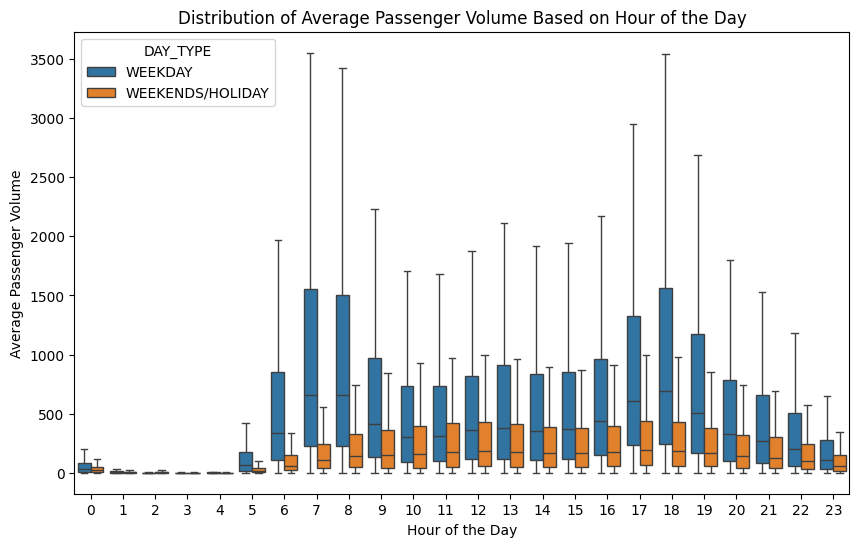

### Resident Population in 2023
We retrieved resident population data from [SingStat](https://www.singstat.gov.sg/find-data/search-by-theme/population/population-and-population-structure/latest-data) since population density in an area can be a key factor for commuters in deciding whether to move to an area. 

To make the data more interpretable for users in the dashboard, we cleaned the data using the below steps: 
1. Categorise the population into 3 age groups: 0-20 years, 21-64 years and 65 years and above.
2. Summarise population based on age groups and region using `GROUPBY`.

The cleaned data can be found in: `../data/pop_by_agegroup.csv`

In [3]:
pop_data = pd.read_csv('../data/respopagesex2023.csv')
pop_data['Age'] = pop_data['Age'].str[:2].astype(int)
pop_data['PA'] = pop_data['PA'].str.upper()

# Define age group thresholds
age_groups = {
    '0-20': (0, 20),
    '21-64': (21, 64),
    '65+': (65, float('inf'))
}

# Function to categorize age into groups
def categorize_age(age):
    for group, (lower, upper) in age_groups.items():
        if lower <= age <= upper:
            return group

# Apply age group categorization
pop_data['AgeGroup'] = pop_data['Age'].apply(categorize_age)

# Group by PA, and AgeGroup, summing up the population
pop_by_agegroup = pop_data.groupby(['PA', 'AgeGroup'])['Pop'].sum().reset_index()
pop_by_agegroup = pop_by_agegroup.pivot(index='PA', columns='AgeGroup', values='Pop').reset_index()
pop_by_agegroup['total_pop'] = pop_by_agegroup['0-20'] + pop_by_agegroup['21-64'] + pop_by_agegroup['65+']
pop_by_agegroup.head()

AgeGroup,PA,0-20,21-64,65+,total_pop
0,ANG MO KIO,26530,96050,39330,161910
1,BEDOK,50240,169290,60700,280230
2,BISHAN,16390,53440,18510,88340
3,BOON LAY,0,0,0,0
4,BUKIT BATOK,34930,106990,27440,169360


## Construction of Connectivity Scores

Here we consider two aspects of connectivity of a residential area, availability (of public transport services) and accessibility (by taking public services). Below are formulaic represeations of the two scores.

### Availability Score

$$
\text{avail\_score} = w_1 \times \text{num\_busstops\_score} + w_2 \times \text{num\_trainstations\_score} + w_3 \times \text{num\_busservices\_score} + w_4 \times \text{avg\_bus\_freq\_score}
$$
$$ \text{where } w_i \text{ are weights to be assigned by the user in the interface and } {\sum_{i=1}^{4} w_i} = 1
$$

### Accessibility Score

$$
\text{access\_score} = w_1 \times \text{cbd\_diff\_score} + w_2 \times \text{ion\_diff\_score} + w_3 \times \text{sgh\_diff\_score} 
$$
$$ \text{where } w_i \text{ are weights to be assigned by the user in the interface and } {\sum_{i=1}^{3} w_i} = 1
$$

We use a weighted average of all the metrics in each category, where the coefficients can be customised by the commuters so long as they add up to 1. In this way, the final scores are dynamic and more representative of the user’s personal preferences. 

For example, a user who only cares about going to the CBD may assign a weight of 1 to `cbd_diff_score` and 0 for the rest when looking at accessibility. 

### Availability Score
The final scores can be found here: `../data/avail_with_score.csv`.

#### Number of Unique Bus Stops per Area, Number of Unique Train Stations per Area
For these 2 metrics defined in our Availability Score: 
- Number of train stations in the region
- Number of bus stops in the region

we summarised the data retrieved from LTA DataMall for each region using a ```GROUPBY``` clause. 

In [ ]:
num_busstops = busstops.groupby('planning_area').size().reset_index(name='num_busstops')
num_trainstations = trainstations.groupby('planning_area').size().reset_index(name='num_trainstations')

#### Number of Unique Bus Services per Area
For this metric:
- Number of bus routes (services) in the region

we performed a join with the `busstops` data to map the planning areas to each bus service and extracted the unique records before summarising the data for each region using the ```GROUPBY``` clause. 

In [13]:
busroutes_planning_area = busroutes.merge(busstops, left_on='BusStopCode', right_on='BusStopCode', how='left')
busroutes_planningarea = busroutes_planning_area[['ServiceNo', 'planning_area']].drop_duplicates()
num_busservices = busroutes_planningarea.groupby('planning_area').size().reset_index(name='num_busservices')

#### Average Frequency of Bus Services per Area
For this metric:
- Average Frequency of Bus Services in each region

we performed another join with the `busroutes_planning_area` data to map the bus frequencies of each service to their respective planning areas.

Next, we further cleaned the data of the frequency columns before calculating the average of the frequencies with a ```GROUPBY``` clause as well. 

In [ ]:
busservices_planning_area = busservices.merge(busroutes_planning_area, left_on='ServiceNo', right_on='ServiceNo', how='left')
busservices_planningarea = busservices_planning_area.iloc[:, [0,2,6,7,8,9,26]].drop_duplicates()

# separate min and max freq
columns = ['AM_Peak_Freq', 'AM_Offpeak_Freq', 'PM_Peak_Freq', 'PM_Offpeak_Freq']
new_columns = ['AM_peak_freq', 'AM_offpeak_freq', 'PM_peak_freq', 'PM_offpeak_freq']

for col, new_col in zip(columns, new_columns):
    busservices_planningarea[[f'{new_col}_min', f'{new_col}_max']] = busservices_planningarea[col].str.split('-', expand=True)

# convert freq to numeric values
for i in range(7, 15):
    column_index = i
    busservices_planningarea.iloc[:, i] = pd.to_numeric(busservices_planningarea.iloc[:, i], errors='coerce')

# drop original freq columns
busservices_planningarea = busservices_planningarea.drop(columns=['AM_Peak_Freq', 'AM_Offpeak_Freq', \
                                                                  'PM_Peak_Freq', 'PM_Offpeak_Freq'])

busservices_freq = busservices_planningarea.copy()

# calculate average frequency
freq_columns = ['AM_peak_freq_min', 'AM_peak_freq_max', 'AM_offpeak_freq_min', 'AM_offpeak_freq_max', \
                'PM_peak_freq_min', 'PM_peak_freq_max', 'PM_offpeak_freq_min', 'PM_offpeak_freq_max']
busservices_freq['avg_bus_freq'] = busservices_freq[freq_columns].mean(axis=1)

avg_freq = busservices_freq.groupby('planning_area')['avg_bus_freq'].mean().reset_index(name='avg_bus_freq')
avg_freq['avg_bus_freq'] = avg_freq['avg_bus_freq'].astype(float).round()

### Accessibility Score
The final scores can be found here: `../data/access_score.csv`.

#### Difference in Travel Time (min) between taking Public and Private Transport
The difference in travel time to each destination is defined by Public Transport Travel Time (`ett`) - Private Transport Travel Time (`ett ave`). 

In [4]:
transitTime = pd.merge(pubTransitTime, priTransitTime, on=['planning_area', 'destination'], how='left')
transitTime['ett_diff'] = transitTime['ett'] - transitTime['ett ave']

accessibility = transitTime.pivot(index='planning_area', columns='destination', values='ett_diff').reset_index()
accessibility.columns = ['planning_area', 'cbd_diff', 'ion_diff', 'sgh_diff']

### Data Normalisation
To construct the final availability and accessibility scores, we performed Min-Max Scaling to scale all metrics into [0,1] to make them comparable. Noting that some metrics like **Average Bus Frequency** are negatively correlated with the connectivity score (e.g. a lower Average Bus Frequency means higher availability), we reversed the direction of these metrics before scaling to ensure that all metrics are positively correlated with the final score. 

Below is an example using `availability` to construct **Availability Score**:

In [12]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# Apply Min-Max scaling to normalize values to positive numbers only
avail_values = availability.drop(columns='planning_area')  # Make a copy to avoid modifying the original DataFrame

# Reverse direction of Freq columns
avail_values['avg_bus_freq'] = - avail_values['avg_bus_freq']

# Shift values by their minimum value to make them positive
avail_values = avail_values - avail_values.min()

# Apply Min-Max scaling to scale values to the range [0, 1]
avail_values = pd.DataFrame(min_max_scaler.fit_transform(avail_values), columns=avail_values.columns)

# Add the avail_values columns back to the DataFrame
avail_values = avail_values.add_suffix('_score')
avail_with_score = pd.concat([availability, avail_values], axis=1)
avail_with_score.head()

,planning_area,num_busstops,num_trainstations,num_busservices,avg_bus_freq,num_busstops_score,num_trainstations_score,num_busservices_score,avg_bus_freq_score
0,BEDOK,286.0,6.0,93.0,14.0,1.000000,0.294118,0.978723,0.882353
1,BUKIT TIMAH,112.0,6.0,37.0,13.0,0.389474,0.294118,0.382979,0.941176
2,BUKIT BATOK,162.0,3.0,56.0,13.0,0.564912,0.117647,0.585106,0.941176
3,BUKIT MERAH,176.0,8.0,66.0,14.0,0.614035,0.411765,0.691489,0.882353
4,CENTRAL WATER CATCHMENT,20.0,NaN,20.0,14.0,0.066667,NaN,0.202128,0.882353


## How to use the scores
To use the constructed scores, simply load the files as shown below.

In [ ]:
import pandas as pd

avail_with_score = pd.read_csv('../data/avail_with_score.csv')
access_with_score = pd.read_csv('../data/access_score.csv')

#### Example Use Case: Top 10 Regions with Highest Overall Connectivity
We can combine both scores to analyse the overall connectivity of regions by taking a simple average of all metric scores.

In [ ]:
# merge both availability and accessibility scores
total_score = pd.merge(avail_with_score, access_with_score, on='planning_area', how='left', suffixes=('_avail', '_access'))
total_score['total_score'] = (total_score['total_score_avail'] + total_score['total_score_access']) / 2
total_score = total_score.sort_values(by='total_score', ascending=False)
total_score[['planning_area', 'total_score_avail', 'total_score_access', 'total_score']].head(10)

We plot the Top 10 Regions with Highest Overall Connectivity below.

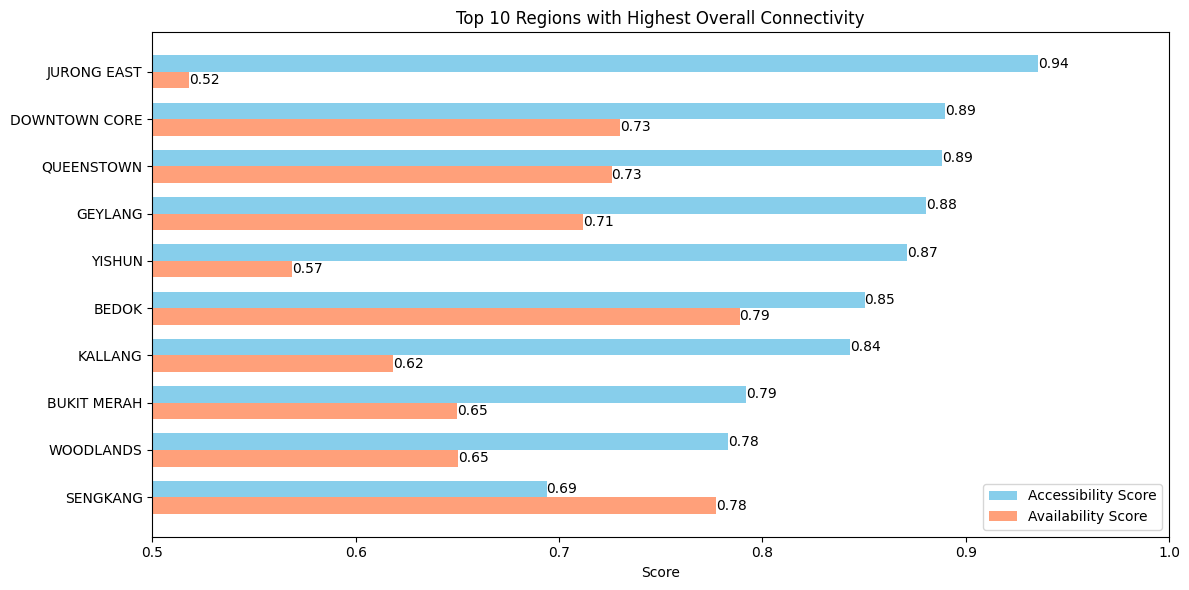